<a href="https://colab.research.google.com/github/arkapriyathecoderinprogress/Codsoft_DS_Projects/blob/main/TitanicSurvivorPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Set visualization style for plots
sns.set(style="whitegrid")

In [45]:
# Load and Inspect the Data
# Function to load the dataset with error handling
def load_dataset(file_path):
  try:
    dataset = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    return dataset
  except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    return None

# Load the Titanic dataset
train_data = load_dataset("/content/train.csv")

Dataset loaded successfully!


In [46]:
# Ensure data is loaded
if train_data is not None:
  # Display the first few rows of the dataset
  print(train_data.head())

  # Display the information to understand the missing values and data types
  print(train_data.info())

  # Display basic statistics for numerical features
  print(train_data.describe())
else:
  raise SystemExit("Dataset could not be loaded. Please check the file path and try again.")

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [47]:
# Data preprocessing and Feature Engineering
# Check if data is loaded
if train_data is not None:
  # Specify features to be used and the target variable
  features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
  target = 'Survived'

  # Extract feature matrix X and target vector y
  X = train_data[features].copy()  # Create an explicit copy
  y = train_data[target]

  # Handle missing values by filling them with median or mode
  # Impute missing values directly in X to ensure changes are reflected
  X['Age'].fillna(X['Age'].median(), inplace=True)
  X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

  # Encode categorical variable to numerical format for modeling
  X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

  # Create new features based on existing ones
  # Family size: sum of siblings/spouses and parents/children plus one (the passenger)
  X['FamilySize'] = X['SibSp'] + X['Parch'] + 1

  # Fare per person: divide fare by family size
  X['FarePerPerson'] = X['Fare'] / X['FamilySize']

  # Check for outliers in 'Age' and 'Fare' using the Interquartile Range (IQR) method
  def handle_outliers(column):
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers to the lower and higher bounds
    X[column] = np.where(X[column] < lower_bound, lower_bound, X[column])
    X[column] = np.where(X[column] > upper_bound, upper_bound, X[column])

  handle_outliers('Age')
  handle_outliers('Fare')

  # Verify that there are no missing values left
  print(X.isnull().sum())  # Check for remaining NaNs

  # Display transformed features
  print(X.head())

Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
Sex_male         0
Embarked_Q       0
Embarked_S       0
FamilySize       0
FarePerPerson    0
dtype: int64
   Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S  \
0       3  22.0      1      0   7.2500      True       False        True   
1       1  38.0      1      0  65.6344     False       False       False   
2       3  26.0      0      0   7.9250     False       False        True   
3       1  35.0      1      0  53.1000     False       False        True   
4       3  35.0      0      0   8.0500      True       False        True   

   FamilySize  FarePerPerson  
0           2        3.62500  
1           2       35.64165  
2           1        7.92500  
3           2       26.55000  
4           1        8.05000  


In [48]:
# Split the data and Feature Scaling
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Initialize Models and Hyperparameters
# Initialize classifiers and hyperparameter grids
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42), {'C': [0.1, 1, 10]}),
    ('Random Forest', RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 200]}),
    ('Support Vector Classifier', SVC(), {'C': [0.1,1,10], 'kernel':['linear', 'rbf']})
]

In [50]:
# Train Models and Evaluate performance with Cross-Validation
# DataFrame to store model results
results_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'Train Accuracy', 'Test Accuracy', 'CV Score Mean', 'Precision', 'Recall', 'F1 Score'])

# Iterate over models and perform hyperparameter tuning using GridSearchCV
for model_name, model, param_grid in models:
  print(f"Training and Tuning {model_name}...")

  # Perform grid search with cross-validation
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
  grid_search.fit(X_train_scaled, y_train)

  # Best model after hyperparameter tuning
  best_model = grid_search.best_estimator_

  # Make predictions on training and testing data
  y_train_pred = best_model.predict(X_train_scaled)
  y_test_pred = best_model.predict(X_test_scaled)

  # Calculate cross-validation score
  cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5)

  # Create a new DataFrame for the current model results
  new_row = pd.DataFrame({
      'Model': [model_name],
      'Best Parameters': [grid_search.best_params_],
      'Train Accuracy': [accuracy_score(y_train, y_train_pred)],
      'Test Accuracy': [accuracy_score(y_test, y_test_pred)],
      'CV Score Mean': [cv_scores.mean()],
      'Precision': [precision_score(y_test, y_test_pred)],
      'Recall': [recall_score(y_test, y_test_pred)],
      'F1 Score': [f1_score(y_test, y_test_pred)]
  })

  # Concatenate the new row to the results DataFrame, handling the empty case
  if results_df.empty:
      results_df = new_row
  else:
      results_df = pd.concat([results_df, new_row], ignore_index=True)

  # Print accuracies and cross-validation scores
  print(f"\n{model_name} Performance:")
  print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
  print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
  print(f"Cross Validation Score Mean: {cv_scores.mean():.2f}")

Training and Tuning Logistic Regression...

Logistic Regression Performance:
Train Accuracy: 0.79
Test Accuracy: 0.81
Cross Validation Score Mean: 0.80
Training and Tuning Random Forest...

Random Forest Performance:
Train Accuracy: 0.98
Test Accuracy: 0.78
Cross Validation Score Mean: 0.81
Training and Tuning Support Vector Classifier...

Support Vector Classifier Performance:
Train Accuracy: 0.86
Test Accuracy: 0.81
Cross Validation Score Mean: 0.83


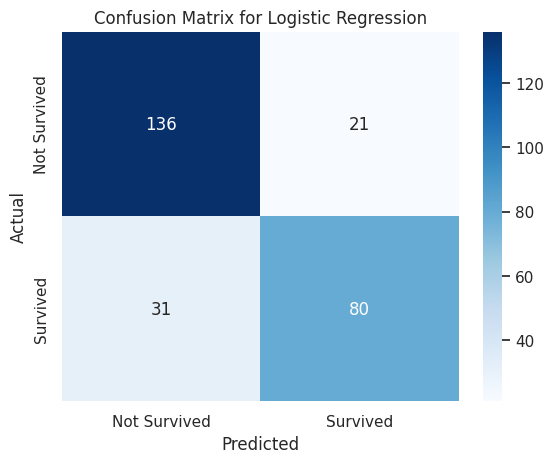

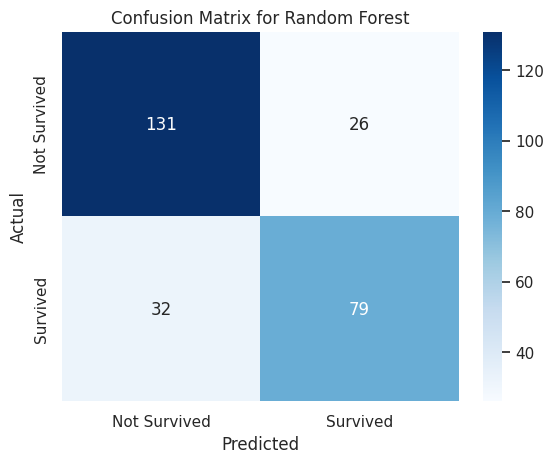

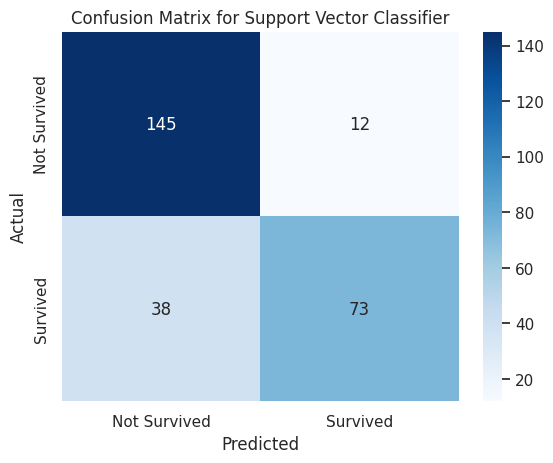

In [51]:
# Visualize Confusion Matrices
# Plot confusion matrices for each model
for model_name, model, _ in models:
    # Retrieve best parameters for the current model
    best_params = results_df[results_df['Model'] == model_name]['Best Parameters'].values[0]

    # Create a new model instance using the best parameters
    if model_name == 'Logistic Regression':
        best_model_instance = LogisticRegression(**best_params, max_iter=1000, random_state=42)
    elif model_name == 'Random Forest':
        best_model_instance = RandomForestClassifier(**best_params, random_state=42)
    elif model_name == 'Support Vector Classifier':
        best_model_instance = SVC(**best_params)

    # Fit the model and make predictions
    best_model_instance.fit(X_train_scaled, y_train)
    y_pred = best_model_instance.predict(X_test_scaled)

    # Confusion matrix for the best model
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Model Comparison:
                       Model            Best Parameters  Train Accuracy  \
0        Logistic Regression                 {'C': 0.1}        0.791332   
1              Random Forest      {'n_estimators': 100}        0.979133   
2  Support Vector Classifier  {'C': 1, 'kernel': 'rbf'}        0.855538   

   Test Accuracy  CV Score Mean  Precision    Recall  F1 Score  
0       0.805970       0.797716   0.792079  0.720721  0.754717  
1       0.783582       0.807471   0.752381  0.711712  0.731481  
2       0.813433       0.828232   0.858824  0.657658  0.744898  


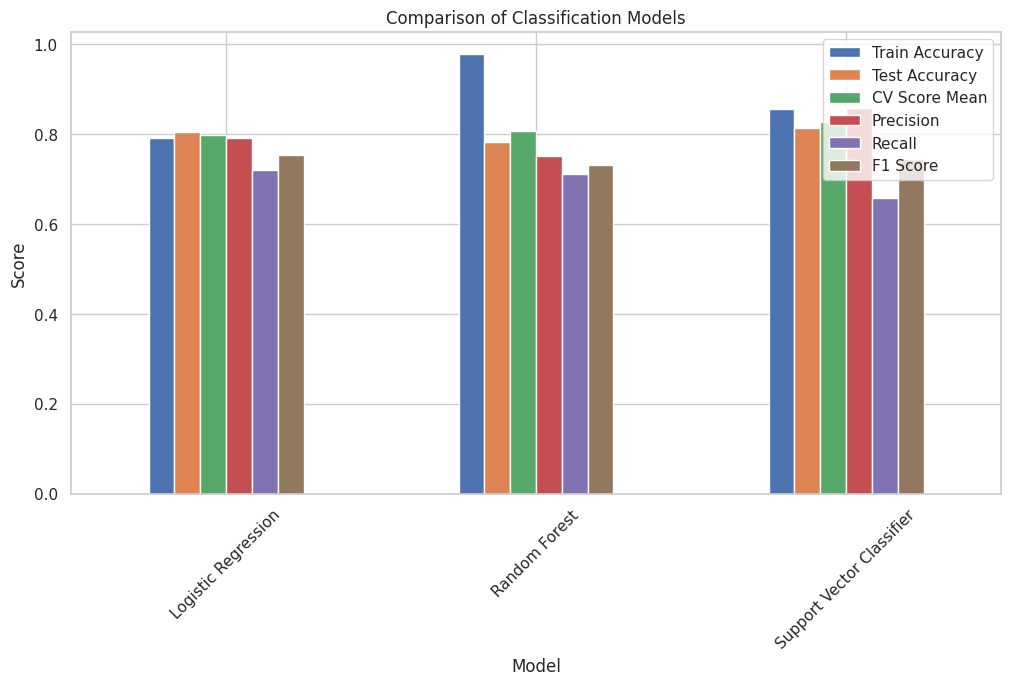

In [52]:
# Compare Model Performance
# Display model comparison results
print("\nModel Comparison:")
print(results_df)

# Plot comparison of model metrics
results_df.set_index('Model')[['Train Accuracy', 'Test Accuracy', 'CV Score Mean', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(12,6))
plt.title('Comparison of Classification Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()